In [1]:
#!pip install lxml
#!pip install bs4

In [2]:
import lxml
import re
import numpy as np
import pandas as pd
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
import typing

from bs4 import BeautifulSoup

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

url1 = 'https://www.imdb.com/search/title?count=100&title_type=feature,tv_series&ref_=nv_wl_img_2'

## 1 - Encontrar o padrão da URL

In [4]:
response = requests.get(url1, headers=headers)
soup = BeautifulSoup(response.text,'html.parser')

In [5]:
movies = soup.find('div', attrs={'class': 'desc'}).get_text() # <----- Busca o número total de filmes (imagem 1)

In [6]:
punc_re = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', str(x).lower())
movies = punc_re(movies)
movies = [float(s) for s in re.findall(r'-?\d+\.?\d*', movies)]
movies = int(movies[1])

In [7]:
print('Número total de filmes: ', movies)

Número total de filmes:  654192


In [8]:
url_list = [url1] # <---- url1 não segue o padrão das páginas seguintes
start = 1
for i in range(0,movies,100):       ### --->>> Cada página contém 100 filmes <<<---
    start +=100
    url_list.append('https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start='+str(start)+'&ref_=adv_nxt')
print(url_list[3])

https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start=301&ref_=adv_nxt


## 2 - Executar webscraping do número de páginas (n) requerido e criar dataframe com as informações

In [9]:
### Definir número de páginas ###
n = 100

In [10]:
### Função para executar webscraping ###
class IMDB(object):
	"""docstring for IMDB"""
	def __init__(self, url):
		super(IMDB, self).__init__()
		page = requests.get(url)

		self.soup = BeautifulSoup(page.content, 'lxml')

	def articleTitle(self):
		return self.soup.find("h1", class_="header").text.replace("\n","")

	def bodyContent(self):
		content = self.soup.find(id="main")
		return content.find_all("div", class_="lister-item mode-advanced")

	def movieData(self):
		movieFrame = self.bodyContent()
		movieTitle = []
		movieDate = []
		movieRunTime = []
		movieGenre = []
		movieRating = []
		movieScore = []
		movieDescription = []
		movieDirector = []
		movieStars = []
		movieVotes = []
		movieGross = []
		for movie in movieFrame:
			
			movieFirstLine = movie.find("h3", class_="lister-item-header")
			
			movieTitle.append(movieFirstLine.find("a").text)
			
			movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))

			try:
				movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
			except:
				movieRunTime.append(np.nan)

			try:
				movieGenre.append(movie.find("span", class_="genre").text.rstrip().replace("\n","").split(","))
			except:
				movieGenre.append(np.nan)

			try:
				movieRating.append(movie.find("strong").text)
			except:
				movieRating.append(np.nan)
			
			try:
				movieScore.append(movie.find("span", class_="metascore unfavorable").text.rstrip())
			except:
				movieScore.append(np.nan)
			
			movieDescription.append(movie.find_all("p", class_="text-muted")[-1].text.lstrip())
			
			movieCast = movie.find("p", class_="")
			try:
				casts = movieCast.text.replace("\n","").split('|')
				casts = [x.strip() for x in casts]
				casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars:"])]
				movieDirector.append(casts[0])
				movieStars.append([x.strip() for x in casts[1].split(",")])
			except:
				casts = movieCast.text.replace("\n","").strip()
				movieDirector.append(np.nan)
				movieStars.append([x.strip() for x in casts.split(",")])

			movieNumbers = movie.find_all("span", attrs={"name": "nv"})

			if len(movieNumbers) == 2:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(movieNumbers[1].text)
			elif len(movieNumbers) == 1:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(np.nan)
			else:
				movieVotes.append(np.nan)
				movieGross.append(np.nan)

		movieData = [movieTitle, movieDate, movieRunTime, movieGenre, movieRating, movieScore, movieDescription, movieDirector, movieStars,movieVotes, movieGross]
		return movieData

In [11]:
if __name__ == '__main__':
	movies_df = pd.DataFrame()
	for i in range(n):  # <------ Número de páginas (n)
		url = url_list[i]
		site = IMDB(url)
		data = site.movieData()
		df = pd.DataFrame(data)	
		df = df.transpose()
		movies_df = movies_df.append(df, ignore_index=True)
	columns = ['movietitle', 'moviedate', 'movieruntime', 'moviegenre', 'movierating', 'moviescore', 'moviedescription', 'moviedirector', 'moviestars', 'movievotes', 'moviegross']
	movies_df.columns = columns

#### Salvar o dataframe sem tratamento dos dados em arquivo .csv

In [12]:
compression_opts = dict(method='zip', archive_name='Movies_Raw.csv')
movies_df.to_csv('Movies_Raw.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 3 - Pré-processamento do texto

In [13]:
movies_df.dropna(subset=['moviegenre','moviedate'],inplace=True)

### Transformar a coluna moviestars string única

In [14]:
movie_stars = []
for row in movies_df.moviestars:
  stars_list = []
  if isinstance(row, typing.List):
    for name in row:
      stars = name.replace('Stars:','')
      stars_list.append(stars)
    row = ', '.join(stars_list)
    movie_stars.append(row)
  else:
    movie_stars.append(row)
movies_df.drop('moviestars', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviestars', movie_stars)

### Transformar a coluna moviegenre em string única e criar coluna dommoviegenre

In [15]:
movie_genre = []
dom_movie_genre = []
i = 0
for row in movies_df.moviegenre:
  genre_list = []
  if isinstance(row, typing.List):
    for genre in row:
      genre_list.append(genre)
      row = ', '.join(genre_list)
    movie_genre.append(row)
    dom_movie_genre.append(genre_list[0])
  else:
    movie_genre.append(row)
    dom_movie_genre.append(row)
  i+=1  
movies_df.drop('moviegenre', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegenre', movie_genre)
movies_df.insert(len(movies_df.columns), 'dommoviegenre', dom_movie_genre)

###  Limpar coluna moviedate e criar coluna moviefirstrun

In [16]:
movie_dates = []
movie_firstrun = []
for row in movies_df.moviedate:
  dates = []
  dates = re.findall(r'-?\d+\.?\d*', row)
  if dates == []:
    movie_firstrun.append(float("NAN"))
    movie_dates.append(float("NAN"))
  else:
    movie_dates.append(' - '.join(dates))
    movie_firstrun.append(dates[0])
    
movies_df.drop('moviedate', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviedate', movie_dates)   
movies_df.insert(len(movies_df.columns), 'moviefirstrun', movie_firstrun)    
    
    
movies_df.dropna(subset=['moviefirstrun','moviedate'],inplace=True)

### Limpar colunas moviegross, movievotes e moviedirector

In [17]:
# Transformar a coluna moviegross em numérica

  # Remove o caracter '.'
movies_df.moviegross = movies_df.moviegross.apply(punc_re)

  # Remove os caracteres não numéricos e multiplica valores não NaN por 1000
movie_gross = []
for row in movies_df.moviegross:
  gross = []
  gross = re.findall(r'-?\d+\.?\d*', row)
  if gross == []:
    movie_gross.append(float("NAN"))
  else:
    for item in gross:
      movie_gross.append(int(item)*1000)
      
movies_df.drop('moviegross', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegross', movie_gross)       

In [18]:
# Remove caracter ',' da coluna movievotes
movies_df.movievotes = movies_df.movievotes.replace(',', '',regex=True)

In [19]:
# Remove string 'Directors:' da coluna moviedirector
movies_df.moviedirector = movies_df.moviedirector.replace('Directors:', '',regex=True)

#### Salvar o dataframe em arquivo .csv

In [20]:
compression_opts = dict(method='zip', archive_name='Movies_Clean.csv')
movies_df.to_csv('Movies_Clean.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 4 - Criar dataframe com filmes organizados por gênero

### Visualizar a distribuição dos filmes pelo gênero dominante

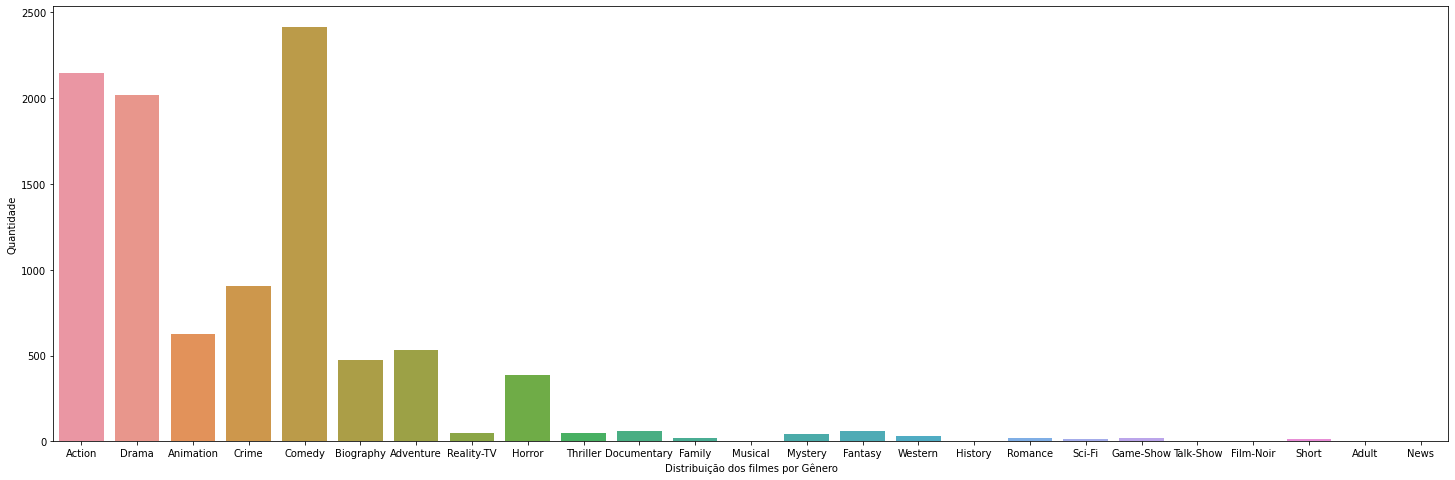

In [21]:
%matplotlib inline
ax = sns.countplot(x = 'dommoviegenre' , data = movies_df)
plt.xlabel("Distribuição dos filmes por Gênero")
plt.ylabel("Quantidade")
fig = plt.gcf()
fig.set_size_inches( 25, 8)
plt.show();

### Criar dataframe com filmes organizados por gênero

In [22]:
movies_genre = movies_df.copy()
movies_genre.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_genre.groupby('dommoviegenre')))
df_grouped_genre = pd.concat(groups, axis=0, join='outer')
df_grouped_genre.drop('dommoviegenre', axis = 1, inplace=True)

In [23]:
df_grouped_genre.tail(20)

movieruntime movierating moviescore  \
        movietitle                                                        
Western Gigantes em Luta                     101         6.9        NaN   
        A Conquista do Oeste                 164         7.1        NaN   
        Quando é Preciso Ser Homem           115         6.9        NaN   
        Chaparral                             60         7.7        NaN   
        Paladino do Oeste                     25         8.4        NaN   
        Raça Brava                            97         6.4        NaN   
        O Caçador de Recompensas             140         3.7        NaN   
        Badland                              117         5.5        NaN   
        Ouro da Discórdia                     87         6.4        NaN   
        Laramie                               60         7.7        NaN   
        Lancer                                60         7.3        NaN   
        Death Valley Days                     25         7.6        NaN   
        Terra Bruta                          109         6.8        NaN   
        Jake Grandão                         110         7.2        NaN   
        Guns 3: Alias Billy the Kid          NaN         NaN        NaN   
        Wanted: Dead or Alive                 30         8.1        NaN   
        The Lone Ranger                       30         7.8        NaN   
        Um Certo Capitão Lockhart            103         7.4        NaN   
        Os Filhos de Katie Elder             122         7.2        NaN   
        The Wild Bunch                       NaN         NaN        NaN   

                                                                      moviedescription  \
        movietitle                                                                       
Western Gigantes em Luta             The story of a man who was shot, robbed and im...   
        A Conquista do Oeste         A family saga covering several decades of West...   
        Quando é Preciso Ser Homem   After a cavalry patrol is ambushed by the Chey...   
        Chaparral                    The Cannon family runs the High Chaparral Ranc...   
        Paladino do Oeste            The adventures of a gentlemanly gunfighter for...   
        Raça Brava                   An English woman and her daughter enlist the a...   
        O Caçador de Recompensas     Haunted by wartime horrors, Civil War soldier-...   
        Badland                      Detective Matthias Breecher is hired to track ...   
        Ouro da Discórdia            When a banker finds his stagecoach shipments o...   
        Laramie                      It is the 1870s in the Wyoming Territory, Slim...   
        Lancer                       Western in the similar to " The Big Valley, Bo...   
        Death Valley Days            Western stories and legends based, and filmed,...   
        Terra Bruta                  A corrupt marshal is pressured by his army fri...   
        Jake Grandão                 In 1909, when John Fain's gang kidnaps Jacob M...   
        Guns 3: Alias Billy the Kid                                       Add a Plot\n   
        Wanted: Dead or Alive        A Civil War veteran with a sawed-off rifle as ...   
        The Lone Ranger              The adventures of the masked hero and his Nati...   
        Um Certo Capitão Lockhart    Newcomer Will Lockhart defies the local cattle...   
        Os Filhos de Katie Elder     Ranch owner Katie Elder's four sons determine ...   
        The Wild Bunch               A gang of American bandits try to elude bounty...   

                                                                         moviedirector  \
        movietitle                                                                       
Western Gigantes em Luta                                                  Burt Kennedy   
        A Conquista do Oeste         John Ford, Henry Hathaway, George Marshall, Ri...   
        Quando é Preciso Ser Homem          

#### Salvar o dataframe em arquivo .csv

In [24]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Genre.csv')
df_grouped_genre.to_csv('Moveis Clean Genre.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 5 - Criar dataframe com filmes organizados por ano

### Visualizar a distribuição dos filmes por data

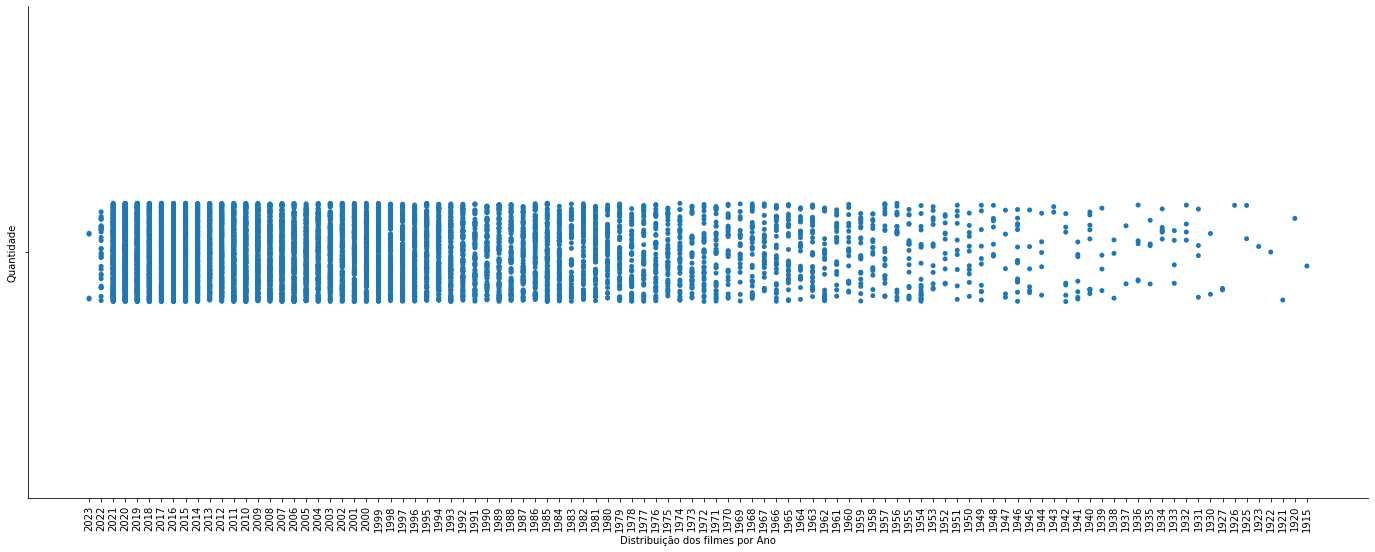

In [25]:
movies_df_sorted = movies_df.sort_values(by=['moviefirstrun'],ascending=False)
ax = sns.catplot(data = movies_df_sorted, x = 'moviefirstrun')
plt.xlabel("Distribuição dos filmes por Ano")
plt.ylabel("Quantidade")
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches( 20, 8)
plt.show();

In [26]:
movies_df_sorted.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_df_sorted.groupby('moviefirstrun')))
df_grouped_date = pd.concat(groups, axis=0, join='outer')
df_grouped_date.drop('moviefirstrun', axis = 1, inplace=True)

In [27]:
df_grouped_date.head(20)

movieruntime movierating moviescore  \
     movietitle                                                              
1915 O Nascimento de Uma Nação                  195         6.3        NaN   
1920 O Gabinete do Dr. Caligari                  76         8.1        NaN   
1921 O Garoto                                    68         8.3        NaN   
1922 Nosferatu                                   94         7.9        NaN   
1923 Rosita                                      99         6.5        NaN   
1925 Em Busca do Ouro                            95         8.2        NaN   
     O Encouraçado Potemkin                      75         8.0        NaN   
1926 A General                                   67         8.1        NaN   
1927 Napoleão                                   330         8.1        NaN   
     Metrópolis                                 153         8.3        NaN   
1930 Sem Novidade no Front                      152         8.0        NaN   
     Marrocos                                    92         7.1        NaN   
1931 Drácula                                     75         7.5        NaN   
     Frankenstein                                70         7.8        NaN   
     Luzes da Cidade                             87         8.5        NaN   
     M, o Vampiro de Dusseldorf                 117         8.3        NaN   
1932 Scarface: A Vergonha de uma Nação           93         7.8        NaN   
     Monstros                                    64         7.9        NaN   
     O Pecado da Carne                           94         6.9        NaN   
     Grande Hotel                               112         7.4        NaN   

                                                                         moviedescription  \
     movietitle                                                                             
1915 O Nascimento de Uma Nação          The Stoneman family finds its friendship with ...   
1920 O Gabinete do Dr. Caligari         Hypnotist Dr. Caligari uses a somnambulist, Ce...   
1921 O Garoto                           The Tramp cares for an abandoned child, but ev...   
1922 Nosferatu                          Vampire Count Orlok expresses interest in a ne...   
1923 Rosita                             Rosita, a peasant singer in Seville, captures ...   
1925 Em Busca do Ouro                   A prospector goes to the Klondike in search of...   
     O Encouraçado Potemkin             In the midst of the Russian Revolution of 1905...   
1926 A General                          When Union spies steal an engineer's beloved l...   
1927 Napoleão                           A film about the French general's youth and ea...   
     Metrópolis                         In a futuristic city sharply divided between t...   
1930 Sem Novidade no Front              A German youth eagerly enters World War I, but...   
     Marrocos                           A cabaret singer and a Legionnaire fall in lov...   
1931 Drácula                            After a naive real estate agent succumbs to th...   
     Frankenstein                       Dr. Frankenstein dares to tamper with life and...   
     Luzes da Cidade                    With the aid of a wealthy erratic tippler, a d...   
     M, o Vampiro de Dusseldorf         When the police in a German city are unable to...   
1932 Scarface: A Vergonha de uma Nação  An ambitious and nearly insane violent gangste...   
     Monstros                           A circus' beautiful trapeze artist agrees to m...   
     O Pecado da Carne                  A prostitute newly arrived in the South Pacifi...   
     Grande Hotel                       A group of very different individuals staying ...   

                                                        moviedirector  \
     movietitle                                                         
1915 O Nascimento de Uma Nação                          D.W. Griffith   
1920 O Gabinete do Dr. Caligari                         

#### Salvar o dataframe em arquivo .csv

In [28]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Date.csv')
df_grouped_date.to_csv('Moveis Clean Date.zip', index=True, compression=compression_opts, encoding='windows-1252')